# LSTM

In [1]:
!pip install googletrans

In [2]:
!pip install wordcloud

In [1]:
# utility
import numpy as np 
import pandas as pd 
import string
import re

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# model 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional
import keras
from keras.utils.np_utils import to_categorical

#nltk and sklearn
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# File path
import os
import os.path
from os import path

# Translator
import googletrans
from googletrans import Translator

# calc accuracy
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 

### Data

In [3]:
# original english file
filename  = '../../Eng-Hin-data/english-anot-shuffled'
orig_df = pd.read_csv(filename + '.csv',  
               delimiter=',')
orig_df.columns = ['Text', 'Label']

In [4]:
orig_df["Text"] = orig_df["Text"].astype(str)
orig_df["Label"] = orig_df["Label"].astype(str)

In [5]:
# Displaying eg tweet
orig_df.Text[6]

"'@SakibulHoque8 @ImranKhanPTI Terrorist is a Muslim.ðŸ˜€"

In [6]:
sentiment =  orig_df['Label'].values

In [7]:
orig_df.groupby('Label').describe()

Text                                                               
      count unique                                                top freq
Label                                                                     
0      3555   3555                                  '@Cruizah Cricket    1
1      2398   2398  Why is JoeBiden's Director of Jewish Outreach ...    1
2      2485   2485  "@AbuSayeedAhmed @nafeul_md It's a comment int...    1

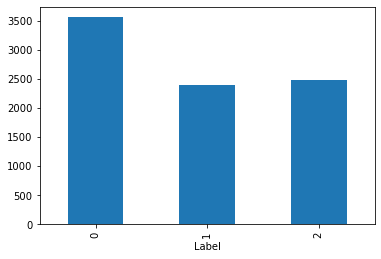

In [8]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,4))
orig_df.groupby('Label').Text.count().plot.bar(ylim=0)
plt.show()

In [9]:
# For entire dataset sentences for each labels 
orig_df.Label.value_counts()

0    3555
2    2485
1    2398
Name: Label, dtype: int64

### Balanced Data

In [10]:
#balancing data 
from collections import Counter
import numpy as np
def balanceClasses(xs, ys):
    item = {}
    new_ys = []
    new_xs = []
    #"""Undersample xs, ys to balance classes."""
    freqs = Counter(ys)
    # the most common class  is the maximum number we want for all classes
    max_allowable = (freqs.most_common()[0][1])
    
    for val in freqs.most_common(): # List
        nums = np.random.randint(1000)
        i = 1
        item[val[0]] = max_allowable - val[1]
        
        if item[val[0]] > 0:            
            while(item[val[0]] - i != 0): 
                nums = nums + 1
                if ys[nums] == val[0]:
                    i += 1
                    new_ys.append(ys[nums])
                    new_xs.append(xs[nums])
    return new_xs, new_ys

In [11]:
new_text, new_label = balanceClasses(orig_df['Text'], orig_df['Label'])

In [12]:
data = pd.DataFrame(new_text)
data.columns = ['Text']
data['Label'] = new_label
data = pd.concat([orig_df, data])

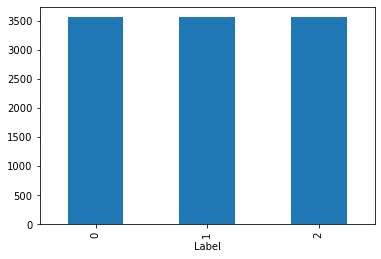

In [13]:
fig1 = plt.figure(figsize=(6,4))
data.groupby('Label').Text.count().plot.bar(ylim=0)
plt.show()

In [14]:
data.Label.value_counts()

0    3555
2    3554
1    3554
Name: Label, dtype: int64

In [15]:


data=data.sample(frac=1).reset_index(drop=True)
data

,Text,Label
0,@parisbinimran @G33kBoyRavi @OfficialDGISPR Pi...,2
1,'@JAfridi10 Ahmad shahzad joined the mangol ar...,0
2,What is your obsession with Mughals? What exac...,2
3,'Paedophile #prophet_muhammed,2
4,'@ABiggestBlunder Muslims are really very dang...,2
...,...,...
10658,'Had a dream where Vicky from the fairly odd p...,2
10659,'@drdavidsamadi Radical Islamic terrorism!,2
10660,'@JimmyNeesh You are the Most Active Cricketer...,0
10661,'@Vijay_cric @daniel86cricket @babarazam258 Wi...,0


### Data Preprocessing

In [16]:
def clean_text(text):
    text = text.lower()
    
    pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    text = pattern.sub('', text)
    text = " ".join(filter(lambda x:x[0]!='@', text.split()))
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)        
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text) 
    text = re.sub(r"\'ll", " will", text)  
    text = re.sub(r"\'ve", " have", text)  
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"did't", "did not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"have't", "have not", text)
    text = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", "", text)
    return text

In [17]:
def CleanTokenize(df):
    tweets = list()
    lines = data["Text"].values.tolist()
    
    for line in lines:
        if isinstance(line, str):
            line = clean_text(line)
        else:
            continue
        # tokenize the text
        tokens = word_tokenize(line)
        # remove puntuations
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        # remove non alphabetic characters
        words = [word for word in stripped if word.isalpha()]
        stop_words = set(stopwords.words("english"))
        # remove stop words
        words = [w for w in words if not w in stop_words]
        tweets.append(words)
    return tweets

def Tokenize(df):
    tweets = list()
    lines = data["Text"].values.tolist()
    
    for line in lines:
        if isinstance(line, str):
            # tokenize the text
            tokens = word_tokenize(line)
        else:
            continue

        tweets.append(tokens)
    return tweets

tweets = CleanTokenize(data)
#tweets = Tokenize(data)


(-0.5, 999.5, 499.5, -0.5)

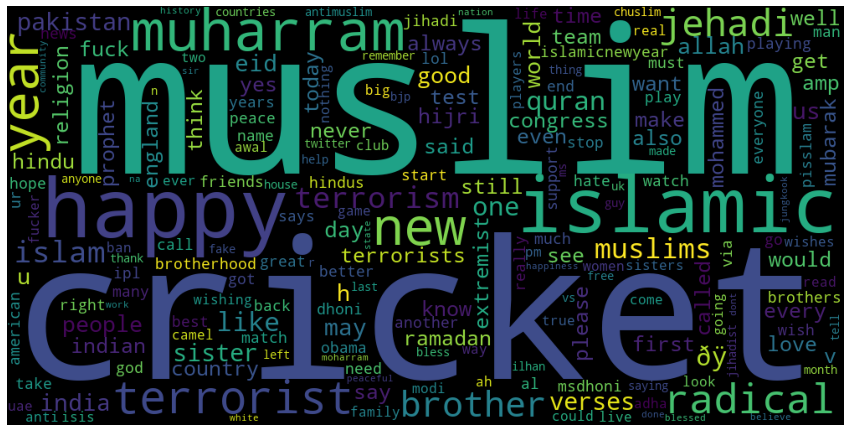

In [18]:
from collections import Counter
from wordcloud import WordCloud, ImageColorGenerator
pos_data = data.loc[data['Label'] == 1]
pos_head_lines = CleanTokenize(pos_data)
pos_lines = [j for sub in pos_head_lines for j in sub] 
word_could_dict=Counter(pos_lines)

wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")

### Splitting data

In [19]:
validation_split = 0.2
max_length = 25


tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(tweets)
sequences = tokenizer_obj.texts_to_sequences(tweets)

word_index = tokenizer_obj.word_index
print("unique tokens - ",len(word_index))
vocab_size = len(tokenizer_obj.word_index) + 1
print('vocab size -', vocab_size)

lines_pad = pad_sequences(sequences, maxlen=max_length, padding='post')
sentiment =  data['Label'].values

indices = np.arange(lines_pad.shape[0])
np.random.shuffle(indices)
lines_pad = lines_pad[indices]
sentiment = sentiment[indices]

le = LabelEncoder()
sentiment = le.fit_transform(sentiment)
# transfor from a array to a vector
sentiment = sentiment.reshape(-1,1)


num_validation_samples = int(validation_split * lines_pad.shape[0])

X_train_pad = lines_pad[:-num_validation_samples]
y_train = sentiment[:-num_validation_samples]

X_test_pad = lines_pad[-num_validation_samples:]
y_test = sentiment[-num_validation_samples:]

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


unique tokens -  14307
vocab size - 14308


In [34]:
print('Shape of X_train_pad:', X_train_pad.shape)
print('Shape of y_train:', y_train.shape)

print('Shape of X_test_pad:', X_test_pad.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train_pad: (8531, 25)
Shape of y_train: (8531, 3)
Shape of X_test_pad: (2132, 25)
Shape of y_test: (2132, 3)


### Glove glove.6B.300d

In [20]:
embeddings_index = {}

# Glove from paper DSWI
f = open('glove.6B.300d.txt', encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))



Found 400000 word vectors.


In [21]:
embedding_dim = 300

embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
c = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        c+=1
        embedding_matrix[i] = embedding_vector

In [22]:
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

## LSTM Model

In [26]:
from tensorflow.keras import optimizers
def createModel(embedding_layer):
    model = Sequential()
    model.add(embedding_layer)
    model.add(LSTM(256, dropout=0.2, recurrent_dropout=0.50))
    model.add(Dense(3, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer = optimizers.RMSprop(learning_rate=1e-3), metrics=['acc'])
    return model

model = createModel(embedding_layer)
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 300)           4292400   
                                                                 
 lstm_3 (LSTM)               (None, 256)               570368    
                                                                 
 dense_3 (Dense)             (None, 3)                 771       
                                                                 
Total params: 4,863,539
Trainable params: 571,139
Non-trainable params: 4,292,400
_________________________________________________________________


In [27]:
history = model.fit(X_train_pad, y_train, batch_size=32, epochs=5, validation_data=(X_test_pad, y_test), verbose=2)

Epoch 1/5
267/267 - 62s - loss: 0.2971 - acc: 0.8936 - val_loss: 0.2884 - val_acc: 0.9109 - 62s/epoch - 232ms/step
Epoch 2/5
267/267 - 42s - loss: 0.2069 - acc: 0.9313 - val_loss: 0.2206 - val_acc: 0.9254 - 42s/epoch - 158ms/step
Epoch 3/5
267/267 - 40s - loss: 0.1792 - acc: 0.9396 - val_loss: 0.2155 - val_acc: 0.9278 - 40s/epoch - 149ms/step
Epoch 4/5
267/267 - 40s - loss: 0.1517 - acc: 0.9529 - val_loss: 0.2576 - val_acc: 0.9306 - 40s/epoch - 150ms/step
Epoch 5/5
267/267 - 42s - loss: 0.1388 - acc: 0.9545 - val_loss: 0.2306 - val_acc: 0.9311 - 42s/epoch - 156ms/step


In [28]:
results = model.evaluate(X_test_pad, y_test, batch_size=32)

67/67 [==============================] - 3s 38ms/step - loss: 0.2306 - acc: 0.9311


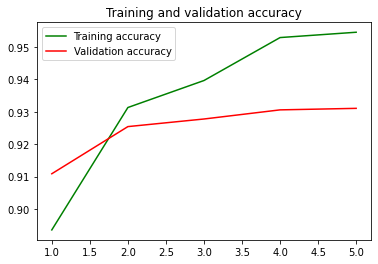

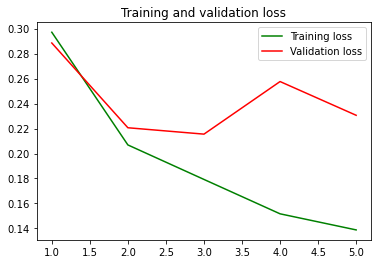

In [29]:
# Plot results
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 10 Fold cross validation

In [30]:
import random
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import KFold
# KFold cross-validation
kFold = 10
scores = []
validation_split = 0.1
max_length = 25
results = []
train_res = []
print("LSTM with Glove from Stanford NLP: ")
for i in range(kFold):
    print("Fold: ", i+1)
    prediction_val = []
    Y_test = []
    scores=[]
    random_shuff = random.randint(1, 7000)
    X_train_pad, X_test_pad, y_train, y_test = train_test_split(lines_pad, to_categorical(sentiment), test_size=0.10, shuffle = True, random_state=random_shuff)
    model = createModel(embedding_layer)
    history = model.fit(X_train_pad, y_train, batch_size=32, epochs=6, validation_data=(X_test_pad, y_test), verbose=1)
    
    print("Results for current fold:")
    print("Evaluating on train data:")
    train_res.append(model.evaluate(X_train_pad, y_train, batch_size=128))
    print("Evaluating on test data:")
    results.append(model.evaluate(X_test_pad, y_test, batch_size=128))
    
    y_pred = model.predict(X_test_pad)
    for p in y_pred:
        prediction_val.append(np.argmax(p))
    for t in y_test:
        Y_test.append(np.argmax(t))
    scoreValue = accuracy_score(Y_test,prediction_val)
    scores.append(scoreValue)



LSTM with Glove from Stanford NLP: 
Fold:  1
Epoch 1/6
300/300 [==============================] - 50s 154ms/step - loss: 0.2972 - acc: 0.8999 - val_loss: 0.2293 - val_acc: 0.9213
Epoch 2/6
300/300 [==============================] - 50s 166ms/step - loss: 0.2138 - acc: 0.9282 - val_loss: 0.1766 - val_acc: 0.9419
Epoch 3/6
300/300 [==============================] - 46s 154ms/step - loss: 0.1821 - acc: 0.9410 - val_loss: 0.1782 - val_acc: 0.9410
Epoch 4/6
300/300 [==============================] - 46s 154ms/step - loss: 0.1586 - acc: 0.9472 - val_loss: 0.1840 - val_acc: 0.9475
Epoch 5/6
300/300 [==============================] - 57s 190ms/step - loss: 0.1386 - acc: 0.9528 - val_loss: 0.2056 - val_acc: 0.9447
Epoch 6/6
300/300 [==============================] - 63s 211ms/step - loss: 0.1230 - acc: 0.9596 - val_loss: 0.1570 - val_acc: 0.9522
Results for current fold:
Evaluating on train data:
75/75 [==============================] - 6s 78ms/step - loss: 0.0767 - acc: 0.9768
Evaluating on te

Results for current fold:
Evaluating on train data:
75/75 [==============================] - 6s 77ms/step - loss: 0.0922 - acc: 0.9687
Evaluating on test data:
9/9 [==============================] - 1s 73ms/step - loss: 0.1988 - acc: 0.9363
Fold:  9
Epoch 1/6
300/300 [==============================] - 50s 157ms/step - loss: 0.3014 - acc: 0.8979 - val_loss: 0.2395 - val_acc: 0.9175
Epoch 2/6
300/300 [==============================] - 46s 154ms/step - loss: 0.2101 - acc: 0.9289 - val_loss: 0.2189 - val_acc: 0.9278
Epoch 3/6
300/300 [==============================] - 47s 156ms/step - loss: 0.1833 - acc: 0.9409 - val_loss: 0.2341 - val_acc: 0.9344
Epoch 4/6
300/300 [==============================] - 46s 155ms/step - loss: 0.1590 - acc: 0.9483 - val_loss: 0.2160 - val_acc: 0.9363
Epoch 5/6
300/300 [==============================] - 47s 156ms/step - loss: 0.1410 - acc: 0.9537 - val_loss: 0.1927 - val_acc: 0.9353
Epoch 6/6
300/300 [==============================] - 47s 156ms/step - loss: 0.11

In [31]:
import statistics 

score = []
for i in results:
    score.append(i[1])
x = statistics.mean(score)
    
print("Kfold Mean: ", x)

Kfold Mean:  0.9451733887195587


### Confusion matrix

In [32]:
results2 = confusion_matrix(Y_test,prediction_val)
print ('Confusion Matrix :')
print(results2) 
print ('Accuracy Score :',accuracy_score(Y_test,prediction_val))
print ('Report : ')
print (classification_report(Y_test,prediction_val))

Confusion Matrix :
[[337   2  12]
 [  4 338  12]
 [  7   5 350]]
Accuracy Score : 0.9606373008434864
Report : 
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       351
           1       0.98      0.95      0.97       354
           2       0.94      0.97      0.95       362

    accuracy                           0.96      1067
   macro avg       0.96      0.96      0.96      1067
weighted avg       0.96      0.96      0.96      1067

